In [1]:
!rm -rf sample_data

In [2]:
!pip install -q --upgrade gdown efficientnet-pytorch

In [3]:
!gdown --id 1DTz_qoC36B-bJnwd17mye-yKrSIp9ZWS
!unzip -qo data.zip && rm data.zip

Downloading...
From: https://drive.google.com/uc?id=1DTz_qoC36B-bJnwd17mye-yKrSIp9ZWS
To: /kaggle/working/data.zip
100%|█████████████████████████████████████████| 478k/478k [00:00<00:00, 114MB/s]


In [4]:
!gdown --id 1PtXs-S5cuzqnn3SiOmZDcnoqe60oiqvZ
!unzip -qo train224.zip && rm train224.zip

Downloading...
From: https://drive.google.com/uc?id=1PtXs-S5cuzqnn3SiOmZDcnoqe60oiqvZ
To: /kaggle/working/train224.zip
818MB [00:08, 92.3MB/s] 


In [1]:
import gc
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
from torchvision.transforms import RandomResizedCrop, RandomRotation, ColorJitter
from efficientnet_pytorch import EfficientNet

In [7]:
def pad(x):
    w, h = x.size; m = np.max([w, h])
    hp, hpr = (m - w) // 2, (m - w) % 2
    vp, vpr = (m - h) // 2, (m - h) % 2
    p = (hp + hpr, vp + vpr, hp, vp)
    return F.pad(x, p, 0, 'constant')

def to_tensor(x, transforms):
    x = Compose(transforms)(x)
    x = ToTensor()(pad(x))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return Normalize(mean, std)(x)

def from_tensor(x):
    x = x.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return np.clip(std * x + mean, 0, 1)

class MelanomaDataset(Dataset):
    
    def __init__(self, files, labels, transforms):
        super().__init__()
        self.files = files
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        x = Image.open(self.files[index])
        x = to_tensor(x, self.transforms)
        return x, self.labels[index]

    def __len__(self):
        return len(self.files)

In [8]:
df = pd.read_csv('train.csv')
df['file'] = 'train224/' + df['image_name'] + '.jpg'
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True, stratify=df['target'])

test_files = test_df['file'].to_list()
train_files = train_df['file'].to_list()
test_labels = test_df['target'].to_list()
train_labels = train_df['target'].to_list()

train_transforms = [RandomHorizontalFlip(), RandomVerticalFlip(), 
                    RandomResizedCrop(224, (0.8, 1.0)), RandomRotation(180), 
                    ColorJitter(brightness=(0.8,1.2), saturation=(0.8,1.2), hue=(-0.1,0.1))]

train_dataset = MelanomaDataset(train_files, train_labels, train_transforms)
test_dataset = MelanomaDataset(test_files, test_labels, [])
train_counts = np.unique(train_labels, return_counts=True)[1]
train_weights = torch.Tensor([1. / train_counts[c] for c in train_labels]).double()
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
# x = Image.open('train224/ISIC_2560463.jpg')
# x = Compose(train_transforms)(x)
# x = ToTensor()(x)
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
# x = Normalize(mean, std)(x)

In [ ]:
# plt.imshow(x)
# x = np.array(x, dtype=np.float32)
# x.min(), x.max()

In [ ]:
# i = iter(train_loader)

In [ ]:
# next(i)[1]

In [ ]:
# train_df['target'].value_counts()

In [ ]:
# test_df['target'].value_counts()

In [ ]:
# len(train_dataset), len(test_dataset)

In [ ]:
# next(iter(train_dataset))[0].shape

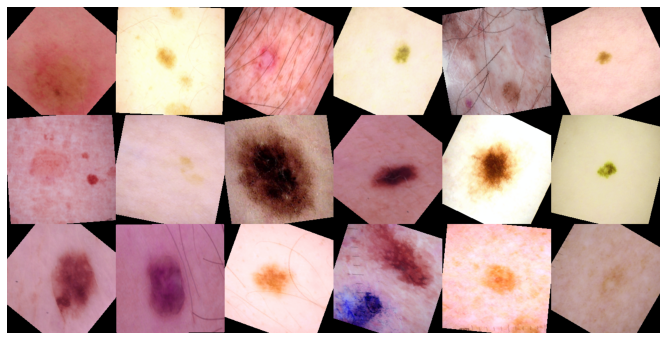

In [9]:
n, ncols = 18, 6

x = [from_tensor(train_dataset[i][0]) for i in range(n)]
x = np.stack(x, axis=0)

n, w, h, c = x.shape
x = x.reshape(n // ncols, ncols, w, h, c)
x = x.swapaxes(1, 2)
x = x.reshape(w * n // ncols, h * ncols, c)

plt.figure(figsize=(12,6))
plt.imshow(x)
plt.axis('off');

In [10]:
def fit_epoch(model, loader, optim, loss_func):
    
    model.train()
    
    m = nn.Sigmoid()
    running_loss = 0.0
    processed_data = 0
    pred, true, prob = [], [], []
    
    with tqdm(loader) as t:
        
        for (data, target) in t:
            
            optim.zero_grad()
            
            data = data.cuda()
            target = target.cuda().float()
            output = model(data).flatten() # !!!
            loss = loss_func(m(output), target)
            
            loss.backward()
            optim.step()
            
            running_loss += loss.item()
            processed_data += data.size(0)
            prob = prob + m(output).tolist()
            true = true + target.int().tolist()
            pred = pred + (m(output) > 0.5).int().tolist()

            t.set_postfix({
                'epoch': epoch + 1, 
                'loss': running_loss / processed_data, 
                'accuracy': accuracy_score(true, pred), 
                'f1': f1_score(true, pred, average='macro', zero_division=0), 
                'recall': recall_score(true, pred, average='macro', zero_division=0), 
                'precision': precision_score(true, pred, average='macro', zero_division=0)
            })

In [11]:
def eval_epoch(model, loader, loss_func):
    
    model.eval()
    
    m = nn.Sigmoid()
    running_loss = 0.0
    processed_data = 0
    pred, true, prob = [], [], []
    
    with tqdm(loader) as t:
        
        for (data, target) in t:
            
            with torch.no_grad():
            
                data = data.cuda()
                target = target.cuda().float()
                output = model(data).flatten() # !!!
                loss = loss_func(m(output), target)
            
                running_loss += loss.item()
                processed_data += data.size(0)
                prob = prob + m(output).tolist()
                true = true + target.int().tolist()
                pred = pred + (m(output) > 0.5).int().tolist()

                t.set_postfix({
                    'epoch': epoch + 1, 
                    'loss': running_loss / processed_data, 
                    'accuracy': accuracy_score(true, pred), 
                    'f1': f1_score(true, pred, average='macro', zero_division=0), 
                    'recall': recall_score(true, pred, average='macro', zero_division=0), 
                    'precision': precision_score(true, pred, average='macro', zero_division=0)
                })

In [ ]:
"""
def run_epoch(model, loader, optim, loss_func, mode):
    
    m = nn.Sigmoid()
    running_loss = 0.0
    processed_data = 0
    pred, true, prob = [], [], []
    
    if mode == 'train': 
        model.train()
    
    else: model.eval()

    with tqdm(loader) as t:
        
        for (data, target) in t:
            
            if mode == 'train':
                optim.zero_grad()
            
            data = data.cuda()
            target = target.cuda().float()
            output = model(data).flatten() # !!!
            loss = loss_func(m(output), target)
            
            if mode == 'train':
                loss.backward()
                optim.step()
            
            running_loss += loss.item()
            processed_data += data.size(0)
            prob = prob + m(output).tolist()
            true = true + target.int().tolist()
            pred = pred + (m(output) > 0.5).int().tolist()

            t.set_postfix({
                'epoch': epoch + 1, 
                'loss': running_loss / processed_data, 
                'accuracy': accuracy_score(true, pred), 
                'f1': f1_score(true, pred, average='macro', zero_division=0), 
                'recall': recall_score(true, pred, average='macro', zero_division=0), 
                'precision': precision_score(true, pred, average='macro', zero_division=0)
            })
"""

In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [13]:
model = EfficientNet.from_pretrained('efficientnet-b6')

for param in model.parameters(): 
    param.requires_grad = True

model._fc = nn.Linear(model._fc.in_features, 1)
model = model.to('cuda')

optim = torch.optim.Adam(model.parameters(), lr=0.000003)

# scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)

loss_func = nn.BCELoss(reduction='sum') # reduction='mean' by default

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b6


In [14]:
for epoch in range(20):
    fit_epoch(model, train_loader, optim, loss_func)
    eval_epoch(model, test_loader, loss_func)

100%|██████████| 104/104 [00:22<00:00,  4.56it/s, epoch=20, loss=0.172, accuracy=0.93, f1=0.592, recall=0.753, precision=0.564]


In [15]:
torch.save(model.state_dict(), 'efficient_net_b6_244x244_epoch20.pt')

In [ ]:
m = nn.Sigmoid()
model.eval()
prob = []
true = []

with tqdm(test_loader) as t:
    for (data, target) in t:
        with torch.no_grad():
            data = data.cuda()
            target = target.cuda().float()
            output = model(data).flatten() # !!!
            prob = prob + m(output).tolist()
            true = true + target.int().tolist()

In [ ]:
pred = [int(p > 0.5) for p in prob]

In [ ]:
accuracy_score(true, pred)

In [ ]:
f1_score(true, pred, average='macro')

In [ ]:
recall_score(true, pred, average='macro')

In [ ]:
precision_score(true, pred, average='macro')

In [ ]:
roc_auc_score(true, prob, average='macro')

In [ ]:
confusion_matrix(true, pred)

In [ ]:
!gdown --id 1bz0VhHDt5arEfelthG1iZ34nLR-QqI4y
!unzip -qo test224.zip && rm test224.zip

In [ ]:
df = pd.read_csv('sample_submission.csv')
df['file'] = 'test224/' + df['image_name'] + '.jpg'
files = df['file'].to_list()
labels = df['target'].to_list()

dataset = MelanomaDataset(files, labels, [])
loader = DataLoader(dataset, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
m = nn.Sigmoid()
model.eval()
prob, pred = [], []

with tqdm(loader) as t:
    for (data, target) in t:
        with torch.no_grad():
            data = data.cuda()
            output = model(data).flatten() # !!!
            prob = prob + m(output).tolist()
            pred = pred + (m(output) > 0.5).int().tolist()

df['target'] = pred
df = df.drop('file', axis=1)
df.to_csv('submission.csv', index=False)

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

In [ ]:
def resize_images(path, size):
    os.mkdir(f'{path}{size}')
    for name in tqdm(os.listdir(path)):
        im = Image.open(f'{path}/{name}')
        im.thumbnail((size, size), Image.ANTIALIAS)
        assert im.size[0] <= size, f'w > {size}'
        assert im.size[1] <= size, f'h > {size}'
        im.save(f'{path}{size}/{name}', 'JPEG', quality=100)

In [ ]:
resize_images('test', 224)

In [ ]:
!zip -r train224.zip train224
from google.colab import files
files.download('train224.zip')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp train224.zip /content/drive/MyDrive

In [50]:
import matplotlib.pyplot as plt

In [12]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [56]:
from PIL import Image

In [66]:
def pad(x):
    w, h = x.size; m = np.max([w, h])
    hp, hpr = (m - w) // 2, (m - w) % 2
    vp, vpr = (m - h) // 2, (m - h) % 2
    p = (hp + hpr, vp + vpr, hp, vp)
    return F.pad(x, p, 0, 'constant')

def to_tensor(x, transforms=[]):
    x = Compose(transforms)(x)
    x = ToTensor()(pad(x))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return Normalize(mean, std)(x)

In [47]:
def from_tensor(x):
    x = x.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return np.clip(std * x + mean, 0, 1)

In [5]:
!gdown --id 1t74E3bt8bzW3ZDHqL4cV2nmlTSXQhmF7 -O model.pt

Downloading...
From: https://drive.google.com/uc?id=1t74E3bt8bzW3ZDHqL4cV2nmlTSXQhmF7
To: /home/vaaliferov/github/paranormal_temp/melanoma/bot/model.pt
164MB [01:06, 2.47MB/s] 


In [84]:
model = EfficientNet.from_name('efficientnet-b6', num_classes=1)
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
model.eval();

In [135]:
model._swish = nn.Identity()

In [136]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        56, 14, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        14, 56, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        56, 32, kernel_siz

In [112]:
def predict(model, im_path):
    x = Image.open(im_path)
    x.thumbnail((224,224), Image.ANTIALIAS)
    x = to_tensor(x).unsqueeze(0)
    y = model(x).detach()[0]
    y = nn.Sigmoid()(y).item()
    return int(y > 0.5), y

In [116]:
predict(model, 'in2.jpg')

(0, 0.013008871115744114)

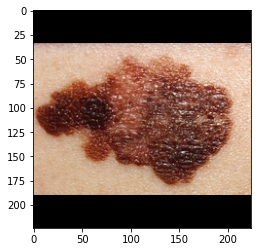

In [71]:
x = from_tensor(x)
plt.imshow(x)